In [1]:
from platform import python_version
import sys

print(sys.executable)
print(python_version())

/Users/chrispap/Documents/EventShapes/env.nosync/bin/python
3.9.5


In [2]:
import numpy as np
import awkward as ak
import uproot
from coffea.nanoevents import NanoEventsFactory, TreeMakerSchema, BaseSchema
from coffea import hist, processor
from coffea.nanoevents.methods import candidate
import matplotlib.pyplot as plt
import mplhep

plt.style.use(mplhep.style.ROOT)
ak.behavior.update(candidate.behavior)

Define processor

In [9]:
def sphericityTensor(particles):
    norm = ak.sum(np.sqrt(particles.x * particles.x + particles.y * particles.y + particles.z * particles.z), axis=1)
    s = np.array([[
                   ak.sum(particles.x * particles.x, axis=1)/norm,
                   ak.sum(particles.x * particles.y, axis=1)/norm,
                   ak.sum(particles.x * particles.z, axis=1)/norm
                  ],
                  [
                   ak.sum(particles.y * particles.x, axis=1)/norm,
                   ak.sum(particles.y * particles.y, axis=1)/norm,
                   ak.sum(particles.y * particles.z, axis=1)/norm
                  ],
                  [
                   ak.sum(particles.z * particles.x, axis=1)/norm,
                   ak.sum(particles.z * particles.y, axis=1)/norm,
                   ak.sum(particles.z * particles.z, axis=1)/norm
                  ]])
        
    return s

def sphericity(s):
    np.nan_to_num(s)
    s_eigvalues = np.linalg.eigvals(np.moveaxis(s, 2, 0))
    sphericity = 1.5*(s_eigvalues[:,1]+s_eigvalues[:,2])
    return sphericity

In [4]:
class TreeMakerProcessor(processor.ProcessorABC):
    def __init__(self):
        self._accumulator = processor.dict_accumulator({
            "sumw": processor.defaultdict_accumulator(float),
            "hist": hist.Hist(
                "Events",
                hist.Cat("dataset", "Dataset"),
                hist.Bin("nTracks", "multiplicity", 50, 0, 250),
                hist.Bin("sph", "sphericity", 50, 0, 1),
            ),
        })

    @property
    def accumulator(self):
        return self._accumulator

    def process(self, events):
        output = self.accumulator.identity()

        dataset = events.metadata['dataset']

        integratedLuminosity = 137.19*1000 # fb^{-1} to pb^{-1}
        
        ht = events.HT
        weights = integratedLuminosity*events.CrossSection[ht > 1200]/len(events)
        tracks = events.Tracks
        tracks_pt = np.sqrt(tracks.x**2 + tracks.y**2)
        tracks_eta = np.arcsinh(tracks.z / tracks_pt)
        finalTracks = (tracks_pt > 1) & (abs(tracks_eta) < 2.5) & (tracks.fromPV0 >= 2) & tracks.matchedToPFCandidate
        nTracks = ak.sum(finalTracks[ht > 1200], axis=1)
        sTensor = sphericityTensor(tracks[finalTracks][ht > 1200])
        sph = sphericity(sTensor)

        output["sumw"][dataset] += len(events)
        output["hist"].fill(
            dataset=dataset,
            nTracks=nTracks,
            sph=sph,
            weight=weights
        )

        return output

    def postprocess(self, accumulator):
        return accumulator

In [21]:
tmFileset = {
    'CMSSW': [
        '/Users/chrispap/QCD/ak15/QCD/Autumn18.QCD_HT1000to1500_TuneCP5_13TeV-madgraphMLM-pythia8_0_RA2AnalysisTree.root',
        '/Users/chrispap/QCD/ak15/QCD/Autumn18.QCD_HT1000to1500_TuneCP5_13TeV-madgraphMLM-pythia8_1_RA2AnalysisTree.root',
        '/Users/chrispap/QCD/ak15/QCD/Autumn18.QCD_HT1000to1500_TuneCP5_13TeV-madgraphMLM-pythia8_2_RA2AnalysisTree.root',
        '/Users/chrispap/QCD/ak15/QCD/Autumn18.QCD_HT1000to1500_TuneCP5_13TeV-madgraphMLM-pythia8_3_RA2AnalysisTree.root',
#        '/Users/chrispap/QCD/ak15/QCD/Autumn18.QCD_HT1000to1500_TuneCP5_13TeV-madgraphMLM-pythia8_4_RA2AnalysisTree.root',
#        '/Users/chrispap/QCD/ak15/QCD/Autumn18.QCD_HT1500to2000_TuneCP5_13TeV-madgraphMLM-pythia8_0_RA2AnalysisTree.root',
#        '/Users/chrispap/QCD/ak15/QCD/Autumn18.QCD_HT1500to2000_TuneCP5_13TeV-madgraphMLM-pythia8_1_RA2AnalysisTree.root',
#        '/Users/chrispap/QCD/ak15/QCD/Autumn18.QCD_HT1500to2000_TuneCP5_13TeV-madgraphMLM-pythia8_2_RA2AnalysisTree.root',
#        '/Users/chrispap/QCD/ak15/QCD/Autumn18.QCD_HT1500to2000_TuneCP5_13TeV-madgraphMLM-pythia8_3_RA2AnalysisTree.root',
#        '/Users/chrispap/QCD/ak15/QCD/Autumn18.QCD_HT1500to2000_TuneCP5_13TeV-madgraphMLM-pythia8_4_RA2AnalysisTree.root',
#        '/Users/chrispap/QCD/ak15/QCD/Autumn18.QCD_HT2000toInf_TuneCP5_13TeV-madgraphMLM-pythia8_0_RA2AnalysisTree.root',
#        '/Users/chrispap/QCD/ak15/QCD/Autumn18.QCD_HT2000toInf_TuneCP5_13TeV-madgraphMLM-pythia8_1_RA2AnalysisTree.root',
#        '/Users/chrispap/QCD/ak15/QCD/Autumn18.QCD_HT2000toInf_TuneCP5_13TeV-madgraphMLM-pythia8_2_RA2AnalysisTree.root',
#        '/Users/chrispap/QCD/ak15/QCD/Autumn18.QCD_HT2000toInf_TuneCP5_13TeV-madgraphMLM-pythia8_3_RA2AnalysisTree.root',
#        '/Users/chrispap/QCD/ak15/QCD/Autumn18.QCD_HT2000toInf_TuneCP5_13TeV-madgraphMLM-pythia8_4_RA2AnalysisTree.root',
    ],
}

tmOut = processor.run_uproot_job(
    tmFileset,
    treename="TreeMaker2/PreSelection",
    processor_instance=TreeMakerProcessor(),
    executor=processor.futures_executor,
    executor_args={
        "schema": TreeMakerSchema,
        "workers": 4
    },
    chunksize=50000
)
tmOut

Preprocessing:   0%|          | 0/1 [00:00<?, ?file/s]

Processing:   0%|          | 0/4 [00:00<?, ?chunk/s]

{'sumw': defaultdict_accumulator(float, {'CMSSW': 200000.0}),
 'hist': <Hist (dataset,nTracks,sph) instance at 0x12eec94c0>}

In [22]:
histo = tmOut['hist'].integrate('dataset', 'CMSSW')

In [23]:
histo

<Hist (nTracks,sph) instance at 0x12ed53cd0>

<AxesSubplot:xlabel='multiplicity', ylabel='Events'>

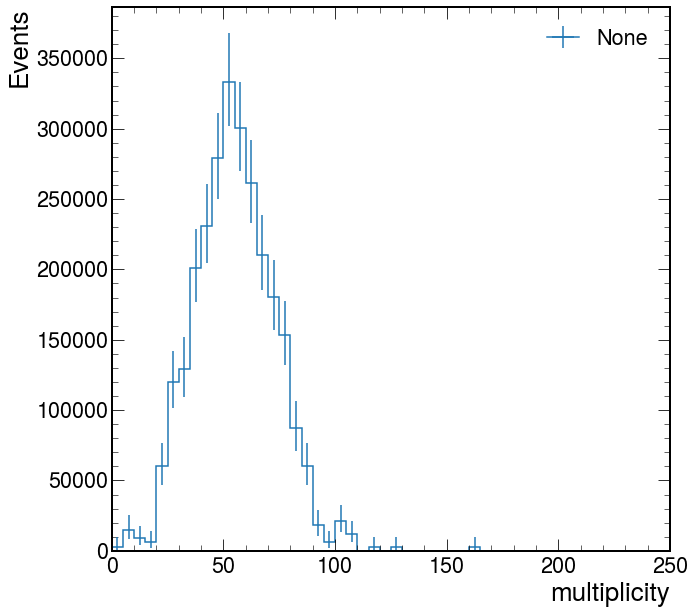

In [24]:
hist.plot1d(histo.sum('sph'))